In [1]:
%%time
from PIL import Image
import json
import numpy as np
from matplotlib import pyplot as plt
import librosa
import soundfile as sf
import librosa.display
import plotly.offline as py
import plotly.graph_objs as go
from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
from skimage.filters import gaussian
import skimage
print(librosa.__version__)

0.6.3
CPU times: user 2.18 s, sys: 280 ms, total: 2.46 s
Wall time: 2.67 s


## define subfunctions

In [2]:
%%time
def rescale(array, range = (0., 1.)):
    _array = np.copy(array)
    if range[1] - range[0] < 0:
        print('Max is smaller than min')
        print('Parameter "range" should be a tuple like (min, max)')
        return
    target_center = sum(range)/2
    target_delta = range[1] - target_center

    # shift center to 0
    current_center = (_array.max() + _array.min()) /2
    _array -= current_center
    # normalize (range will be (0, 1))
    _array /= np.max(_array)
    # multiple to target range
    _array *= target_delta
    # shift center
    _array += target_center
    return _array


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 25.7 µs


In [4]:
%%time
def setup_fig(z):
    trace = go.Heatmap(
        z=z,
    )

    data = [trace]

    layout = go.Layout(
        title='Partial Data',
        height=720,
        scene=dict(
            xaxis=dict(
                title=dict(
                    text='Time',
                ),
            ),
            yaxis=dict(
                title=dict(
                    text='Frequency',
                ),
                autorange=False
            ),
        )
    )
    return go.Figure(data, layout)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 31.2 µs


# Spectrogram Segmentation

## Short Time Fourier Transform

In [3]:
%%time
y, sr = librosa.load( "./assets/audio/resampled/bird.wav" )

D = librosa.stft(y)
S, phase = librosa.magphase(D)
orig_S = S.copy()
print(S.dtype, phase.dtype, np.allclose(D, S * phase))
print(S.min(), S.max())
for i, x in enumerate(S):
    S[i] = rescale(x)
print(S.min(), S.max())


float32 complex64 True
5.449545e-08 277.85605
-5.9604645e-08 1.0
CPU times: user 710 ms, sys: 30 ms, total: 740 ms
Wall time: 770 ms


 ## Plot Spectrogram

CPU times: user 240 ms, sys: 100 ms, total: 340 ms
Wall time: 255 ms


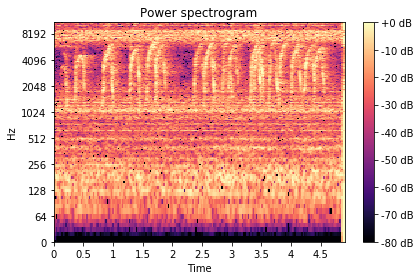

In [4]:
%%time
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

## Convert to Image

In [8]:
%%time
img = skimage.img_as_float(S)
img = rescale_intensity(img, in_range=(0, 1),
                         out_range=(-1, 1))






CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.24 ms


In [9]:
%%time
py.plot(setup_fig(img), filename='spectrogram_original_img.html')

CPU times: user 940 ms, sys: 240 ms, total: 1.18 s
Wall time: 1.82 s


'file:///home/jovyan/work/spectrogram_original_img.html'

## Smoothing Image

In [15]:
%%time
img = gaussian(img, sigma=(8, 0.4))

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 21.6 ms


In [16]:
%%time
py.plot(setup_fig(img), filename='spectrogram_smoothed_img.html')

CPU times: user 510 ms, sys: 40 ms, total: 550 ms
Wall time: 621 ms


'file:///home/jovyan/work/spectrogram_smoothed_img.html'

## Segmentation

In [11]:
%%time
# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(img.shape, dtype=np.uint)
markers[img < -0.5] = 1
markers[img > -0.1] = 2


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 ms


In [12]:
%%time
# Run random walker algorithm
labels = random_walker(img, markers, beta=10, mode='bf')


CPU times: user 170 ms, sys: 80 ms, total: 250 ms
Wall time: 257 ms


In [13]:
%%time
py.plot(setup_fig(markers), filename='spectrogram_markers.html')
py.plot(setup_fig(labels), filename='spectrogram_labels.html')

CPU times: user 340 ms, sys: 40 ms, total: 380 ms
Wall time: 439 ms


In [14]:
%%time
outobj = dict(spectrogram = orig_S.tolist(), segmentation = labels.tolist(), songname = "bird")

with open('./output/bird.json', 'w') as outfile:
    json.dump(outobj, outfile)

CPU times: user 680 ms, sys: 30 ms, total: 710 ms
Wall time: 748 ms
